# Imports

In [26]:
import requests
import zipfile
import io
import sys

from lonboard import Map, SolidPolygonLayer
from lonboard.layer_extension import DataFilterExtension
import ipywidgets as widgets

import pandas as pd
import numpy as np
import geopandas as gpd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.ticker as mticker

from shapely.geometry import Polygon

import seaborn as sns

# Fetch Data
Our population data is stored in a .csv file inside a zip folder. Let’s fetch it and load it into a pandas DataFrame.

In [16]:
url = "https://www.zensus2022.de/static/Zensus_Veroeffentlichung/Zensus2022_Bevoelkerungszahl.zip"
target_file = "Zensus2022_Bevoelkerungszahl_100m-Gitter.csv"

In [17]:
response = requests.get(url)

with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref: # Open the ZIP file in memory
    with zip_ref.open(target_file) as csv_file:
        df_pop = pd.read_csv(csv_file, delimiter=';') 

In [18]:
df_pop.head()

,GITTER_ID_100m,x_mp_100m,y_mp_100m,Einwohner
0,CRS3035RES100mN2689100E4337000,4337050,2689150,4
1,CRS3035RES100mN2689100E4341100,4341150,2689150,11
2,CRS3035RES100mN2690800E4341200,4341250,2690850,4
3,CRS3035RES100mN2691200E4341200,4341250,2691250,12
4,CRS3035RES100mN2691300E4341200,4341250,2691350,3


In [22]:
df_pop.rename( columns = {'Einwohner':'Population'}, inplace = True)

In [27]:
def create_polygon(x, y, half_length=50):
    return Polygon([
        (x - half_length, y - half_length),
        (x + half_length, y - half_length),
        (x + half_length, y + half_length),
        (x - half_length, y + half_length)
    ])

In [29]:
gdf_population = gpd.GeoDataFrame(df_pop['Population'], geometry = df_pop.apply(lambda row: create_polygon(row['x_mp_100m'], row['y_mp_100m']), axis = 1), crs = 'EPSG:3035')

In [35]:
gdf_population = gdf_population.to_crs(epsg = 4326)

In [37]:
gdf_population.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3088037 entries, 0 to 3088036
Data columns (total 2 columns):
 #   Column      Dtype   
---  ------      -----   
 0   Population  int64   
 1   geometry    geometry
dtypes: geometry(1), int64(1)
memory usage: 47.1 MB


In [39]:
gdf_population.head()

,Population,geometry
0,4,"POLYGON ((10.21146 47.31529, 10.21278 47.31529..."
1,11,"POLYGON ((10.26565 47.31517, 10.26697 47.31517..."
2,4,"POLYGON ((10.26705 47.33047, 10.26837 47.33046..."
3,12,"POLYGON ((10.26707 47.33407, 10.26839 47.33407..."
4,3,"POLYGON ((10.26707 47.33497, 10.26839 47.33497..."


In [41]:
polygon_layer = SolidPolygonLayer.from_geopandas(gdf_population)

In [42]:
m = Map(polygon_layer)

In [43]:
m

Map(layers=[SolidPolygonLayer(table=pyarrow.Table
Population: uint16
geometry: list<item: list<item: fixed_siz…

In [60]:
polygon_layer.get_fill_color = [11, 127, 171]

In [97]:
colormap = mpl.colormaps["YlOrRd"]

In [98]:
normalizer = mpl.colors.Normalize(0, gdf_population['Population'].max())

In [99]:
colors = colormap(normalizer(gdf_population['Population']), bytes = True)

In [100]:
polygon_layer.get_fill_color = colors

<Axes: xlabel='Population', ylabel='Count'>

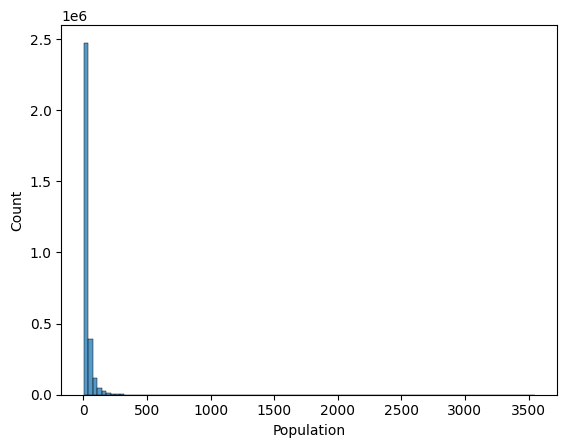

In [76]:
sns.histplot(gdf_population['Population'], bins = 100)

In [77]:
gdf_population['Population'].skew()

np.float64(4.7072006305650085)

In [101]:
normalizer = mpl.colors.LogNorm(gdf_population['Population'].min(), gdf_population['Population'].max())

In [102]:
colors = colormap(normalizer(gdf_population['Population']), bytes = True)

In [103]:
polygon_layer.get_fill_color = colors

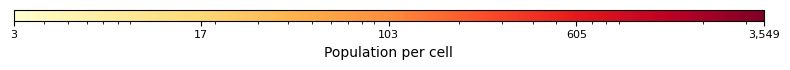

In [105]:
def thousands_formatter(x, pos):
    return f'{int(x):,}'

def create_colorbar():
    fig, ax = plt.subplots(figsize=(8, 0.8))
    
    # Define the colorbar with LogNorm and the specified colormap
    cbar = plt.colorbar(
        plt.cm.ScalarMappable(norm=LogNorm(vmin=gdf_population['Population'].min(), vmax=gdf_population['Population'].max()), cmap=colormap),
        cax=ax,
        orientation='horizontal'
    )
    
    tick_values = np.logspace(np.log10(gdf_population['Population'].min()), np.log10(gdf_population['Population'].max()), num=5)
    cbar.set_ticks(tick_values)
    cbar.ax.xaxis.set_major_formatter(mticker.FuncFormatter(thousands_formatter))
    cbar.ax.tick_params(labelsize=8)

    cbar.set_label('Population per cell', fontsize=10)
    
    plt.tight_layout()
    plt.show()

create_colorbar()

In [106]:
m.to_html("visualize_pop.html")

In [107]:
!open visualize_pop.html

In [108]:
filter_extension = DataFilterExtension()

In [109]:
polygon_layer = SolidPolygonLayer.from_geopandas(
    gdf_population,
    get_fill_color = colors,
    extensions=[filter_extension],
    get_filter_value=gdf_population['Population'], 
    filter_range=[3, 3549] 
)

In [115]:
with widgets.Output():
    # Create the slider
    slider = widgets.IntRangeSlider(
        value=(3, 25),
        min=3,
        max=3549,
        step=1,
        description="Slider: ",
        layout=widgets.Layout(width='600px'), 
    )

    # Link the slider to the polygon layer 
    widgets.jsdlink(
        (slider, "value"),
        (polygon_layer, "filter_range")
    )

In [116]:
slider

IntRangeSlider(value=(3, 25), description='Slider: ', layout=Layout(width='600px'), max=3549, min=3)

In [117]:
m = Map(polygon_layer)
m

Map(layers=[SolidPolygonLayer(extensions=[DataFilterExtension()], filter_range=[3.0, 25.0], get_fill_color=<py…

In [118]:
polygon_layer = SolidPolygonLayer.from_geopandas(
    gdf_population,
    get_fill_color= colors,
    extruded = True
)

In [119]:
polygon_layer.get_elevation = 1500 * normalizer(gdf_population['Population'])

In [120]:
m = Map(polygon_layer)
m

Map(layers=[SolidPolygonLayer(extruded=True, get_elevation=<pyarrow.lib.FloatArray object at 0x44d630c40>
[
  …